<a href="https://colab.research.google.com/github/keatonwalker/sgid-stats/blob/master/sgid_log_timeseries.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Explore the SGID lock logs as a time series
Inspired by DataQuest arcticle: [Tutorial: Time Series Analysis with Pandas](https://www.dataquest.io/blog/tutorial-time-series-analysis-pandas/) written by Jennifer Walker

#Authenticate with your email first

run this and get a code.

In [3]:
from google.colab import auth
from google.colab import files
auth.authenticate_user()
print('Authenticated')

Authenticated


In [0]:
import pandas as pd

#Helper Functions

In [0]:
from google.cloud import bigquery

def _print_bytes_readable(byte_count):
  """Convert byte count to a more readable form and print."""
  conversion = None
  unit = None
  if byte_count < 921600:
    conversion = 0.000976562
    unit = 'KB'
  elif byte_count < 9.437e+8:
    conversion = 9.53674e-7
    unit = 'MB'
  elif byte_count < 1.063e+12:
    conversion = 9.31323e-10
    unit = 'GB'
  else:
    conversion = 9.09495e-13
    unit = 'TB'
 
  print("This query will process {} {}".format(
    round(byte_count * conversion, 4), unit))
  print("This query will cost ${}(rounded)".format(
    round((byte_count * 9.31323e-10) * (500/1024.0), 4)))

def print_query_size(query_string, project_id):
  client = bigquery.Client(project=project_id)
  job_config = bigquery.QueryJobConfig()
  job_config.dry_run = True
  job_config.use_query_cache = False
  query_job = client.query(
      query_string,
      # Location must match that of the dataset(s) referenced in the query.
      location='US',
      job_config=job_config)  # API request

  bytes_processed = query_job.total_bytes_processed
  _print_bytes_readable(bytes_processed)
  

def get_dataframe_from_query(query_string, project_id):
  client = bigquery.Client(project=project_id)
  job_config = bigquery.QueryJobConfig()
  job_config.use_query_cache = True
  df = client.query(
      query_string,
      location='US',
      job_config=job_config).to_dataframe()
  return df

#SQL Query as a string

In [0]:
query_string = (
"""
WITH
  lock_counts_by_type AS (
  SELECT
    DATETIME_TRUNC(lock_time,
      HOUR) AS lock_hour,
    COUNT(*) AS lock_count,
    COUNT(DISTINCT(table_name)) AS table_count,
    COUNT(DISTINCT(nodename)) AS node_count,
    CASE
      WHEN nodename LIKE 'SE%' THEN 'desktop'
      ELSE 'server'
    END AS lock_source
  FROM
    `sgid_stats.locks`
  GROUP BY
    lock_hour,
    lock_source )
#Pivot
SELECT
  lock_hour,
  SUM(CASE
      WHEN lock_source = 'server' THEN lock_count
      ELSE 0 END) AS server_lock_count,
  SUM(CASE
      WHEN lock_source = 'desktop' THEN lock_count
      ELSE 0 END) AS desktop_lock_count,
  SUM(CASE
      WHEN lock_source = 'server' THEN node_count
      ELSE 0 END) AS server_node_count,
  SUM(CASE
      WHEN lock_source = 'desktop' THEN node_count
      ELSE 0 END) AS desktop_node_count,
  SUM(CASE
      WHEN lock_source = 'server' THEN table_count
      ELSE 0 END) AS server_table_count,
  SUM(CASE
      WHEN lock_source = 'desktop' THEN table_count
      ELSE 0 END) AS desktop_table_count
FROM
  lock_counts_by_type
GROUP BY
  lock_hour
order by
  lock_hour
"""
)


#Test the query size first

In [7]:
print_query_size(query_string, 'agrc-204220')

This query will process 116.0399 MB
This query will cost $0.0553(rounded)


#Run the query and get a dataframe

In [0]:
locks = get_dataframe_from_query(query_string, 'agrc-204220')

In [9]:
locks.shape

(3234, 7)

In [10]:
locks.head(3)

,lock_hour,server_lock_count,desktop_lock_count,server_node_count,desktop_node_count,server_table_count,desktop_table_count
0,2018-08-31 13:00:00,3,4,2,1,3,4
1,2018-08-31 14:00:00,37,7,1,2,18,7
2,2018-08-31 15:00:00,56,56,1,3,18,23


In [11]:
locks.dtypes

lock_hour              datetime64[ns]
server_lock_count               int64
desktop_lock_count              int64
server_node_count               int64
desktop_node_count              int64
server_table_count              int64
desktop_table_count             int64
dtype: object

#Explore the lock_hour

Use pandas time series functions.

## First the time field needs to be set as the index of the frame

In [0]:
locks.set_index('lock_hour', inplace=True)


In [13]:
locks.index

DatetimeIndex(['2018-08-31 13:00:00', '2018-08-31 14:00:00',
               '2018-08-31 15:00:00', '2018-08-31 16:00:00',
               '2018-08-31 17:00:00', '2018-08-31 18:00:00',
               '2018-08-31 19:00:00', '2018-08-31 20:00:00',
               '2018-08-31 21:00:00', '2018-08-31 22:00:00',
               ...
               '2019-01-13 09:00:00', '2019-01-13 10:00:00',
               '2019-01-13 11:00:00', '2019-01-13 12:00:00',
               '2019-01-13 13:00:00', '2019-01-13 14:00:00',
               '2019-01-13 15:00:00', '2019-01-13 16:00:00',
               '2019-01-13 17:00:00', '2019-01-13 18:00:00'],
              dtype='datetime64[ns]', name='lock_hour', length=3234, freq=None)

## Use partial string indexing to look at one day

In [14]:
locks.loc['2018-09-01']

,server_lock_count,desktop_lock_count,server_node_count,desktop_node_count,server_table_count,desktop_table_count
lock_hour,,,,,,
2018-09-01 00:00:00,406,0,2,0,9,0
2018-09-01 01:00:00,319,0,2,0,9,0
2018-09-01 02:00:00,10737,0,4,0,621,0
2018-09-01 03:00:00,3,0,1,0,3,0
2018-09-01 04:00:00,5,0,1,0,1,0
2018-09-01 05:00:00,19,0,2,0,8,0
2018-09-01 06:00:00,6,0,1,0,4,0
2018-09-01 07:00:00,22,0,1,0,13,0
2018-09-01 08:00:00,40,4,1,1,15,4


## Parse the time index to add a few more fields to the frame

In [15]:
locks['month'] = locks.index.month
locks['day_name'] = locks.index.weekday_name
locks['hour_of_day'] = locks.index.hour
locks.sample(5, random_state=0)

,server_lock_count,desktop_lock_count,server_node_count,desktop_node_count,server_table_count,desktop_table_count,month,day_name,hour_of_day
lock_hour,,,,,,,,,
2018-09-30 18:00:00,5,0,1,0,4,0,9,Sunday,18
2018-10-19 02:00:00,10819,0,3,0,626,0,10,Friday,2
2018-09-25 15:00:00,124,22,2,6,20,14,9,Tuesday,15
2018-12-18 17:00:00,28,16,2,4,15,12,12,Tuesday,17
2018-12-21 06:00:00,44,31,2,3,12,19,12,Friday,6


# Make a few graphs of counts over 1 hour periods
### Compare server and desktop metrics


In [0]:
# Graph libraries settings
import matplotlib.pyplot as plt

# Display figures inline in Jupyter notebook
%matplotlib inline

import seaborn as sns
# Use seaborn style defaults and set the default figure size
sns.set(rc={'figure.figsize':(11, 4)})

## Total lock count

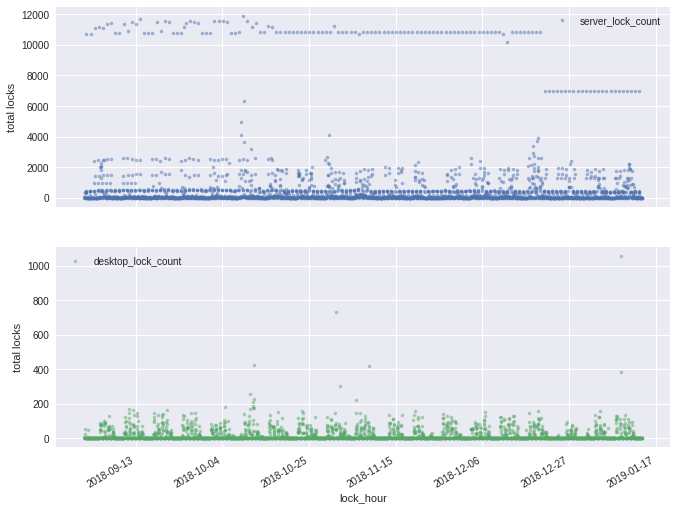

In [17]:
cols_plot = ['server_lock_count', 'desktop_lock_count']
axes = locks[cols_plot].plot(marker='.', alpha=0.5, linestyle='None', figsize=(11, 9), subplots=True)
for ax in axes:
    ax.set_ylabel('total locks')

## Count of unique server and desktop machines creating locks

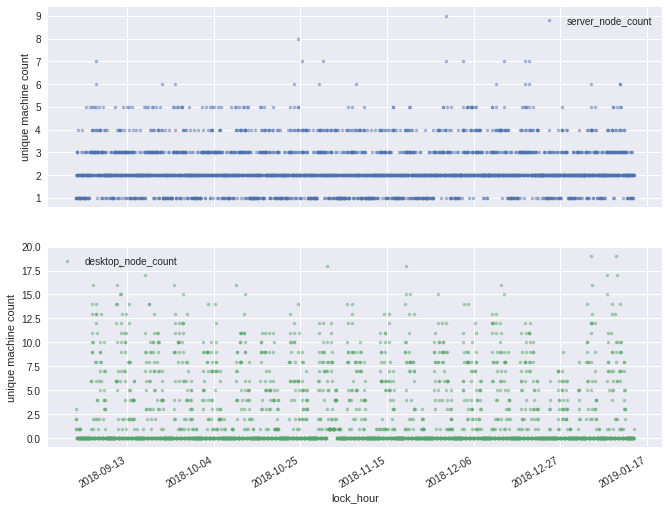

In [18]:
cols_plot = ['server_node_count', 'desktop_node_count']
axes = locks[cols_plot].plot(marker='.', alpha=0.5, linestyle='None', figsize=(11, 9), subplots=True)
for ax in axes:
    ax.set_ylabel('unique machine count')

## Count of unique table names that were locked

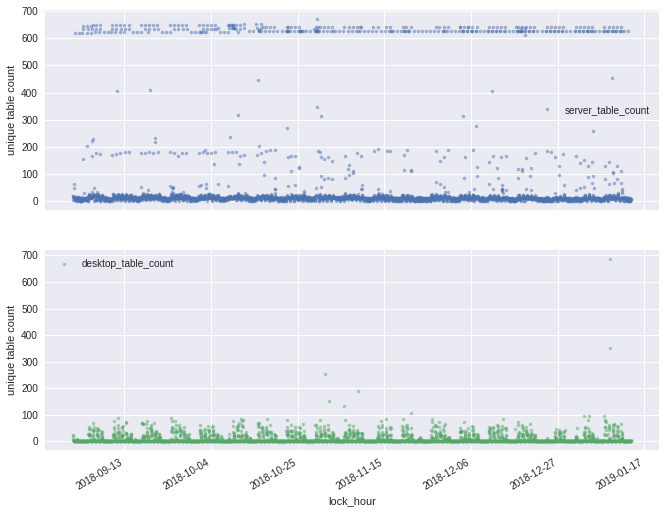

In [19]:
cols_plot = [ 'server_table_count', 'desktop_table_count']
axes = locks[cols_plot].plot(marker='.', alpha=0.5, linestyle='None', figsize=(11, 9), subplots=True)
for ax in axes:
    ax.set_ylabel('unique table count')

# Look at the repetitive (seaonal) time periods

Use the time index and partial string matching to look at one month.

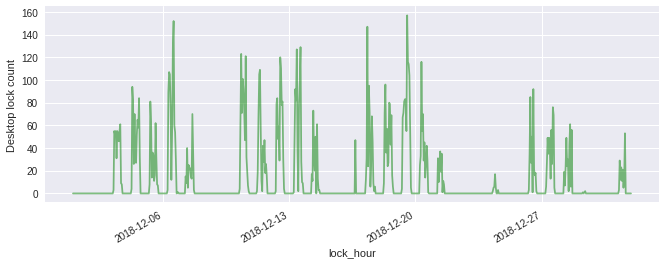

In [20]:
ax = locks.loc['2018-12', 'desktop_lock_count'].plot(color='green', alpha=0.5)
ax.set_ylabel('Desktop lock count');

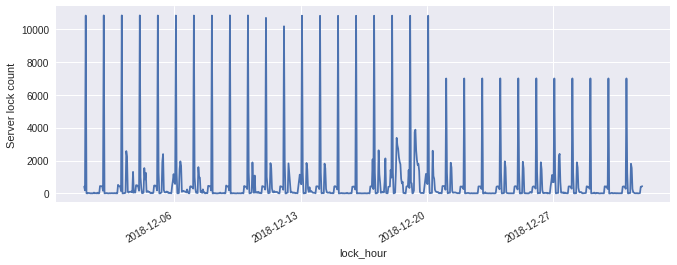

In [21]:
ax = locks.loc['2018-12', 'server_lock_count'].plot()
ax.set_ylabel('Server lock count');

## Focus in on the change in nightly server lock counts
Around 12-20 there was a change in the nightly spike in locks. Focus the graph around the change to try and see what happened.

In [0]:
import matplotlib.dates as mdates

def align_plot_to_monday(df, start_date, end_date, column, y_label, title, color='#1f77b4'):
  """Helper function to align graphs around work weeks"""
  fig, ax = plt.subplots()
  ax.plot(df.loc[start_date: end_date, column], linestyle='-', color=color)
  ax.set_ylabel(y_label)
  ax.set_title(title)

  # Set x-axis major ticks to weekly interval, on Mondays
  ax.xaxis.set_major_locator(mdates.WeekdayLocator(byweekday=mdates.MONDAY))

  # Format x-tick labels as 3-letter month name and day number
  ax.xaxis.set_major_formatter(mdates.DateFormatter('Mon %b %d')); 

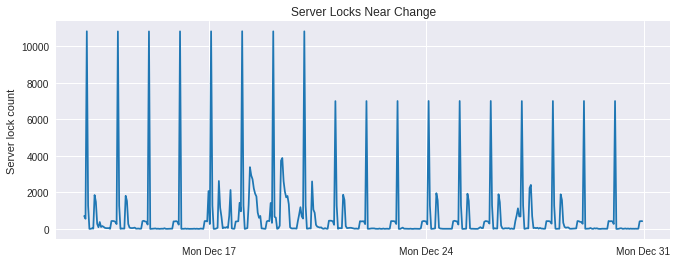

In [23]:
align_plot_to_monday(locks,
                     '2018-12-13',
                     '2018-12-30', 
                     'server_lock_count',
                     'Server lock count',
                     'Server Locks Near Change')

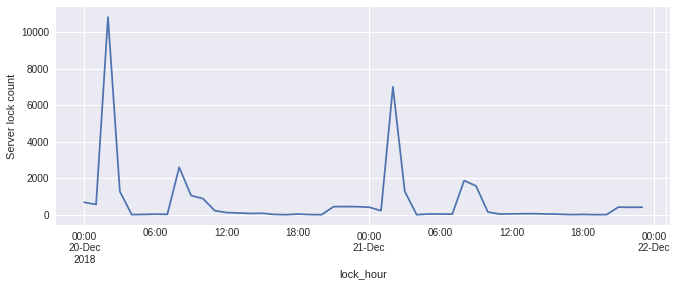

In [24]:
ax = locks.loc['2018-12-20 00:00:00': '2018-12-21 23:00:00', 'server_lock_count'].plot()
ax.set_ylabel('Server lock count');

The spike in server locks happens every night. Forklift only runs on weekdays.

What is the megalocker and why did it's lock count change on December 21st?

# Look at hourly seasonality for desktop locks

In [0]:
# Make a function to help build box plots
def align_box_plots(df, metric_columns, period_column, y_label, show_outliers=False):
  """Make boxplots for multiple metric columns"""
  fig, axes = plt.subplots(len(metric_columns),
                           1,
                           figsize=(11, 10), 
                           sharex=True)
  for name, ax in zip(metric_columns, axes):
      sns.boxplot(
          data=df, 
          x=period_column,
          y=name,
          ax=ax,
          showfliers=show_outliers)
      ax.set_ylabel(y_label)
      ax.set_title(name)

      # Remove the automatic x-axis label from all but the bottom subplot
      if ax != axes[-1]:
          ax.set_xlabel('')

Limit counts to weekday because weekends are mostly zeros 

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:454: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)


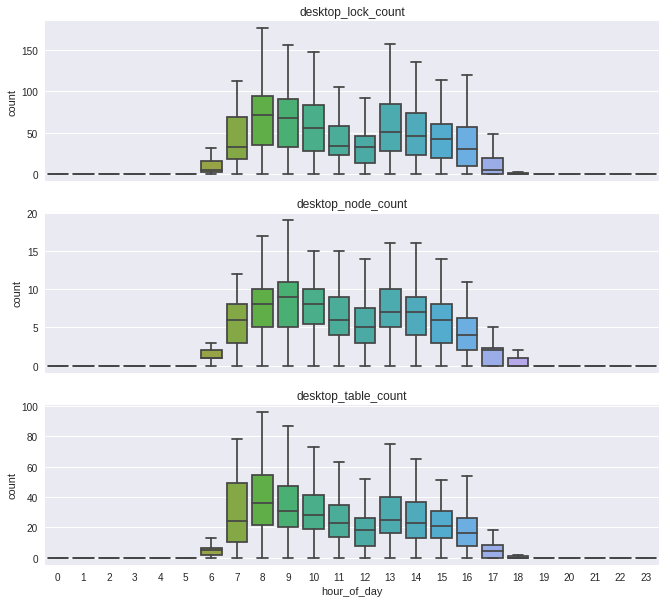

In [26]:
weekday_counts = locks.loc[locks['day_name'].isin(['Monday',
                                  'Tuesday',
                                  'Wednesday',
                                  'Thursday',
                                  'Friday'])]
align_box_plots(
    weekday_counts,
    ['desktop_lock_count', 'desktop_node_count', 'desktop_table_count'],
    'hour_of_day',
    'count')

# Resample and window server locks

## The full server lock graph is not very useful
The daily mega-locking outlier obscures all other patterns.

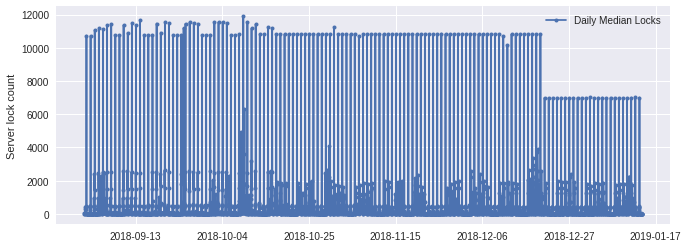

In [27]:
fig, ax = plt.subplots()

ax.plot(locks.loc[:, 'server_lock_count'],
        marker='.', markersize=8, linestyle='-', label='Daily Median Locks')

ax.set_ylabel('Server lock count')
ax.legend();

## Resample the data to see other patterns
Resample the data to daily frequency and aggregate with a median to reduce the effects of outliers.

In [30]:
# Specify the data columns we want to include (i.e. exclude Year, Month, Weekday Name)
metric_columns = ['server_lock_count', 'server_node_count', 'server_table_count']

# Resample to weekly frequency, aggregating with mean
server_daily_median = locks[metric_columns].resample('D').median()
server_daily_median.head(3)

,server_lock_count,server_node_count,server_table_count
lock_hour,,,
2018-08-31,56.0,2.0,14.0
2018-09-01,12.5,2.0,8.5
2018-09-02,9.5,2.0,6.0


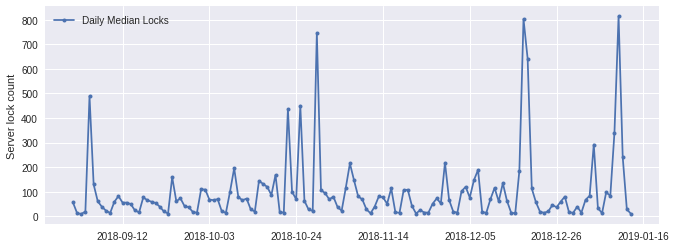

In [31]:
fig, ax = plt.subplots()

ax.plot(server_daily_median.loc[:, 'server_lock_count'],
        marker='.', markersize=8, linestyle='-', label='Daily Median Locks')

ax.set_ylabel('Server lock count')
ax.legend();

Now a spike of server locks is apperant near the end of October.

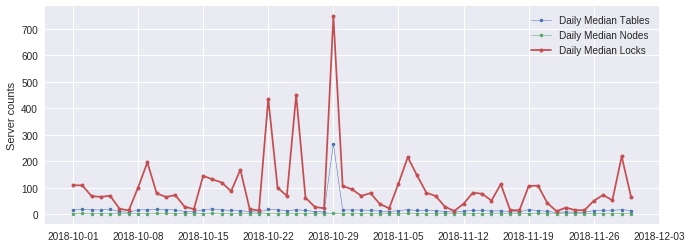

In [32]:
# Start and end of the date range to extract
start, end = '2018-10', '2018-11'

# Plot all resampled metrics together
fig, ax = plt.subplots()

ax.plot(server_daily_median.loc[start:end, 'server_table_count'],
        marker='.', linestyle='-', linewidth=0.5, label='Daily Median Tables')
ax.plot(server_daily_median.loc[start:end, 'server_node_count'],
        marker='.', linestyle='-', linewidth=0.5, label='Daily Median Nodes')

ax.plot(server_daily_median.loc[start:end, 'server_lock_count'],
        marker='.', markersize=8, linestyle='-', label='Daily Median Locks')

ax.set_ylabel('Server counts')
ax.legend();